# Desafio Sprint 3

## Etapa 1: ambiente

Nesta etapa devemos certificar que as bibliotecas **pandas** e **matplotlib** estão instaladas no ambiente atual.
Podemos importar ambas as bibliotecas com o comando:
```bash
python.exe -m pip install matplotlib pandas
```

Ao longo do projeto, também serão necessárias algumas bibliotecas adicionais.
```bash
python.exe -m pip install tabulate
```

Portanto recomenda-se instalar os pacotes necessários lendo o arquivo [requirements.txt](requirements.txt):
```bash
# Rodar comando na pasta do desafio
python.exe -m pip install -r requirements.txt
```

Podemos conferir a lista de pacotes instalados usando o comando:
```bash
python.exe -m pip freeze
```

## Etapa 2: desenvolvimento

Funcões utilitárias:

In [2]:
import pandas as pd # biblioteca de tratamento de dados
from IPython.display import display, Markdown # Exibição dos dados em tabelas markdown
from random import randint  # Funcao para gerar numeros aleatorios
from matplotlib import pyplot as plt # Biblioteca para plotar graficos

#Nome das colunas do CSV como constantes
APP =                  "App"
CATEGORY =        "Category"
RATING =            "Rating"
REVIEWS =          "Reviews"
SIZE =               "Size"
INSTALLS =        "Installs"
TYPE =                "Type"
PRICE =              "Price"
AGE_RANGE = "Content Rating"
GENRE =            "Genres"
L_UPDATE =    "Last Updated"
C_VERSION =    "Current Ver"
A_VERSION =    "Android Ver"

# Funcao para exibir dataframes como tabelas markdown no notebook
def display_df_table(table: pd.DataFrame, show_index=True) -> None:
    display(Markdown(table.to_markdown(index=show_index)))

### 1. Leitura e Tratamento dos Dados de [googleplaystore.csv](./googleplaystore.csv)

Como primeiro passo devemos importar os dados. 

In [3]:
# Importando arquivo csv e convertendo para objeto dataframe
raw_dataframe = pd.read_csv("googleplaystore.csv") # Caminho relativo ao path deste notebook

# Mostrando primeiro registro do csv
display_df_table(raw_dataframe.head(1), False)

| App                                            | Category       |   Rating |   Reviews | Size   | Installs   | Type   |   Price | Content Rating   | Genres       | Last Updated    | Current Ver   | Android Ver   |
|:-----------------------------------------------|:---------------|---------:|----------:|:-------|:-----------|:-------|--------:|:-----------------|:-------------|:----------------|:--------------|:--------------|
| Photo Editor & Candy Camera & Grid & ScrapBook | ART_AND_DESIGN |      4.1 |       159 | 19M    | 10,000+    | Free   |       0 | Everyone         | Art & Design | January 7, 2018 | 1.0.0         | 4.0.3 and up  |

Em seguida podemos remover todos os registros duplicados

In [4]:
# Removendo duplicatas
distinct_dataframe = raw_dataframe.drop_duplicates()
removed_registers = (len(raw_dataframe) - len(distinct_dataframe))

print(f"Número de Registros Bruto: {len(raw_dataframe):>14}")
print(f"Número de Registros Distintos: {len(distinct_dataframe):>10}")
print(f"Número de Registros Removidos: {removed_registers:>10}")

Número de Registros Bruto:          10841
Número de Registros Distintos:      10358
Número de Registros Removidos:        483


Podemos agora analisar o formato dos dados de cada coluna e tratar/filtrar de forma mais profunda

#### 1. Coluna "App"

Vamos observar os dados dessa coluna:

In [5]:
# Exibindo 10 registros variados da coluna "App"
display_df_table(distinct_dataframe[::randint(700, 1000)][APP].head(10))
# Este bloco pode ser executado diversas vezes para ter maior noção dos dados

|      | App                                                |
|-----:|:---------------------------------------------------|
|    0 | Photo Editor & Candy Camera & Grid & ScrapBook     |
| 1153 | NetSpend Prepaid                                   |
| 2258 | IBM Micromedex Drug Info                           |
| 3417 | Petals 3D live wallpaper                           |
| 4455 | pixiv                                              |
| 5456 | AP English Language: Practice Tests and Flashcards |
| 6459 | BatControl Pro                                     |
| 7469 | Brainf*ck Interpreter                              |
| 8471 | Eyewitness Travel Phrase Book                      |
| 9481 | Period Tracker, Pregnancy Calculator & Calendar 🌸 |

Podemos notar que nesta coluna praticamente tem um pouco de tudo. 

Como o nome do aplicativo é uma informação muito importante para sua identificação, vamos apenas checar se a coluna possuí algum valor nulo.

In [6]:
# Conta quantos valores em "App" sao nulos
app_missing_count = distinct_dataframe[APP].isnull().sum()
null_app_percent = (app_missing_count / len(distinct_dataframe)) * 100


print(f"Valores nulos na coluna {APP}: {app_missing_count:>22}")
print(f"Porcentagem de valores nulos na coluna {APP}: {null_app_percent:>6.2f}%")


Valores nulos na coluna App:                      0
Porcentagem de valores nulos na coluna App:   0.00%


O arquivo não contém nenhum valor nulo na coluna "App", portanto não precisamos realizar nenhum tratamento.

In [7]:
# Troca de nomeclatura para indicar coluna validada
valid_app_dataframe = distinct_dataframe

#### 2. Coluna "Category"

Vamos observar os dados dessa coluna:

In [8]:
# Exibindo 10 registros variados da coluna "Category"
display_df_table(distinct_dataframe[::randint(700, 1000)][CATEGORY].head(10))
# Este bloco pode ser executado diversas vezes para ter maior noção dos dados

|      | Category           |
|-----:|:-------------------|
|    0 | ART_AND_DESIGN     |
|  942 | ENTERTAINMENT      |
| 1862 | GAME               |
| 2818 | PHOTOGRAPHY        |
| 3718 | NEWS_AND_MAGAZINES |
| 4570 | FAMILY             |
| 5394 | GAME               |
| 6220 | SHOPPING           |
| 7053 | PERSONALIZATION    |
| 7877 | FAMILY             |

Podemos notar que o formato padrão para esta coluna são palavras em letras maíuscula separadas por *underline*.
Vamos filtrar os registros que não seguem esta regra:

In [9]:
# Expressão regular que checa letras maíusculas e underline
category_pattern = r"[A-Z_]"

# Cria um objeto Series com valores True|False que serve como máscara de busca 
category_mask = valid_app_dataframe[CATEGORY].str.match(category_pattern)

# Usa máscara criada para filtrar as linhas com "Category" válidas
valid_category_dataframe = valid_app_dataframe[category_mask]

removed_registers = (len(valid_app_dataframe) - len(valid_category_dataframe))

print(f"Número de Registros Bruto: {len(distinct_dataframe):>14}")
print(f"Número de Registros Válidos: {len(valid_category_dataframe):>12}")
print(f"Número de Registros Removidos: {removed_registers:>10}")

Número de Registros Bruto:          10358
Número de Registros Válidos:        10357
Número de Registros Removidos:          1


#### 3. Coluna "Rating"

Esta coluna representa a avaliação de um aplicativo. Como indicado pelas [políticas de avaliação](https://play.google/intl/pt-BR/comment-posting-policy/) da plataforma, a avaliação de um aplicativo é um valor entre 1 e 5 que representa a média de avaliações dos usuários da ultima versão do aplicativo (campo "Current Ver").

Vamos verificar a quantidade de valores fora do range 1-5 e também quantos valores nulos temos:


In [10]:
out_of_range_rating_dataframe = valid_category_dataframe[
    # Seleciona apenas registros com Rating fora do range 1-5
    (valid_category_dataframe[RATING] < 1) | (valid_category_dataframe[RATING] > 5)
]

rating_missing_count = valid_category_dataframe[RATING].isnull().sum()
null_rating_percent = (rating_missing_count / len(valid_category_dataframe)) * 100

print(f"Valores fora do range válido em {RATING}: {len(out_of_range_rating_dataframe):>14}")
print(f"Valores nulos na coluna {RATING}: {rating_missing_count:>22}")
print(f"Porcentagem de valores nulos na coluna {RATING}: {null_rating_percent:>6.2f}%")

Valores fora do range válido em Rating:              0
Valores nulos na coluna Rating:                   1465
Porcentagem de valores nulos na coluna Rating:  14.15%


Não temos números fora do range estabelecido para serem removidos.

Como a quantidade de valores nulos em "Rating" representa uma parcela considerável dos valores e provavelmente indica que o aplicativo não possui avaliações em quantidade suficiente, é preferível mantê-los para aumentar a quantidade de registros disponíveis para análise de outros fatores.

In [11]:
# Troca de nomeclatura para indicar coluna validada
valid_rating_dataframe = valid_category_dataframe

#### 4. Coluna "Reviews

Seguindo a [políticas de avaliação](https://play.google/intl/pt-BR/comment-posting-policy/) da plataforma, podemos assumir que este campos representa a quantidade total de avaliações que um aplicativo possui

Vamos tratar os valores inválidos, podemos considerar inválido qualquer valor fora do conjunto $\mathbb{N}_0$:

In [12]:
# Mascara que valida apenas valores inteiros
reviews_int_mask = valid_rating_dataframe[REVIEWS].apply(lambda n: int(n) == float(n))

# Mascara que valida apenas valores positivos
reviews_unsigned_mask = valid_rating_dataframe[REVIEWS].apply(lambda n: float(n) >= 0)

# Usa as mascaras criadas para retornar apenas os valores invalidos
valid_reviews_dataframe = valid_rating_dataframe[reviews_int_mask & reviews_unsigned_mask]

reviews_removed_registers = len(valid_rating_dataframe) - len(valid_reviews_dataframe)

print(f"Número de registros antes do tratamento de {REVIEWS}: {len(valid_rating_dataframe):>10}")
print(f"Número de valores válidos na coluna {REVIEWS}: {len(valid_reviews_dataframe):>17}")
print(f"Número de registros removidos em {REVIEWS}: {reviews_removed_registers:>20}")

Número de registros antes do tratamento de Reviews:      10357
Número de valores válidos na coluna Reviews:             10357
Número de registros removidos em Reviews:                    0


#### 5. Coluna "Size"

Vamos observar os dados dessa coluna:

In [13]:
# Exibindo 10 registros variados da coluna "Size"
display_df_table(distinct_dataframe[::randint(700, 1000)][SIZE].head(10))
# Este bloco pode ser executado diversas vezes para ter maior noção dos dados

|      | Size               |
|-----:|:-------------------|
|    0 | 19M                |
|  919 | Varies with device |
| 1830 | 70M                |
| 2744 | 21M                |
| 3654 | Varies with device |
| 4490 | 2.1M               |
| 5298 | 11M                |
| 6108 | 2.5M               |
| 6923 | 12M                |
| 7733 | 3.5M               |

Esta coluna possui o seguinte padrão:    
1. Um valor específico: [Numero][Base] (19M = 19MB, 19000KB, 19000000B)
2. Uma string "Varies with device"

Vamos tratar os valores que fogem deste padrão:

In [14]:
# Expressao regular que verifica padrao [Numero][Base] ou "Varies with device"
size_pattern_1 = r"[\d.]+[a-zA-Z]"
size_pattern_2 = r"(Varies with device)"

# Cria mascara indicando valores validos perante expressao regular acima
size_pattern_mask_1 = valid_reviews_dataframe[SIZE].str.match(size_pattern_1)
size_pattern_mask_2 = valid_reviews_dataframe[SIZE].str.match(size_pattern_2)

# Dataframe apenas com valores que que atendem alguma expressao regular
valid_size_dataframe = valid_category_dataframe[size_pattern_mask_1 | size_pattern_mask_2]

size_removed_registers = len(valid_reviews_dataframe) - len(valid_size_dataframe)

print(f"Número de registros antes do tratamento de {SIZE}: {len(valid_reviews_dataframe):>10}")
print(f"Número de valores válidos na coluna {SIZE}: {len(valid_size_dataframe):>17}")
print(f"Número de registros removidos {SIZE}: {size_removed_registers:>23}")

Número de registros antes do tratamento de Size:      10357
Número de valores válidos na coluna Size:             10357
Número de registros removidos Size:                       0


Por ultimo é interessante padronizar os valores de uma maneira que permita os ordenar numericamente:

In [15]:
def normalize_size(value: str) -> str:
    if value == "Varies with device": return value
    
    # Verifica ultimo caracter do valor e retorna uma string
    # com o tamanho do app em kb
    match value[-1]:
        case "M": 
            return str(float(value[:-1]) * 1000)
        case "k": 
            return value[:-1]

# Crie uma cópia do dataframe
normalized_size_dataframe = valid_size_dataframe.copy(deep=True)

# Substitue os valores da coluna "Size" 
normalized_size_dataframe[SIZE] = normalized_size_dataframe[SIZE].apply(normalize_size)

#### 6. Coluna "Installs"

Vamos observar os dados dessa coluna:

In [16]:
# Exibindo 10 registros variados da coluna "Installs"
display_df_table(distinct_dataframe[::randint(700, 1000)][INSTALLS].head(10))
# Este bloco pode ser executado diversas vezes para ter maior noção dos dados

|      | Installs     |
|-----:|:-------------|
|    0 | 10,000+      |
| 1030 | 100+         |
| 1992 | 100,000,000+ |
| 3009 | 5,000,000+   |
| 3975 | 100,000,000+ |
| 4865 | 100,000+     |
| 5749 | 50,000+      |
| 6640 | 1,000+       |
| 7525 | 10,000,000+  |
| 8409 | 10,000+      |

Os valores se encontram no formato americano ("," como separador de milhares) com um "+" ao final. 

Podemos assumir que esta coluna deve receber apenas valores com o conjunto de caracteres descritos acima: 

In [17]:
# Expressao regular que verifica se a strin possui apenas 
# numeros, "," e "+".
installs_pattern = r"([\d,+]+)"

# Cria uma mascara de busca para valores que atendem a expressao regular
intalls_pattern_mask = normalized_size_dataframe[INSTALLS].str.match(installs_pattern)

# Usa a mascara criada para retornar registros com valores validos
valid_installs_dataframe = normalized_size_dataframe[intalls_pattern_mask]

installs_removed_registers = len(normalized_size_dataframe) - len(valid_installs_dataframe)

print(f"Número de registros antes do tratamento de {INSTALLS}: {len(normalized_size_dataframe):>10}")
print(f"Número de valores válidos na coluna {INSTALLS}: {len(valid_installs_dataframe):>17}")
print(f"Número de registros removidos {INSTALLS}: {installs_removed_registers:>23}")

Número de registros antes do tratamento de Installs:      10357
Número de valores válidos na coluna Installs:             10357
Número de registros removidos Installs:                       0


### 2. Os 5 Aplicativos Mais Instalados

Para descobrirmos os aplicativos mais instalados da plataforma, podemos utilizar o campo "Installs" encontrado na tabela que apresenta o número de instalações no seguinte padrão:

In [18]:
# Exibindo 5 registros variados da coluna "Installs"
display_df_table(distinct_dataframe[::randint(1700, 2000)][INSTALLS].head())
# Este bloco pode ser executado diversas vezes para ter maior noção dos dados

|      | Installs   |
|-----:|:-----------|
|    0 | 10,000+    |
| 2066 | 1,000,000+ |
| 4121 | 50,000+    |
| 5963 | 5,000+     |
| 7810 | 500,000+   |

Os valores se encontram no formato americano ("," como separador de milhares) com um "+" ao final. 

Podemos assumir que esta coluna deve receber apenas valores com o conjunto de caracteres descritos acima: 

In [19]:
# Expressao regular que verifica se a strin possui apenas 
# numeros, "," e "+".
installs_pattern = r"([\d,+]+)"

# Cria uma mascara de busca para valores que atendem a expressao regular
intalls_pattern_mask = distinct_dataframe[INSTALLS].str.match(installs_pattern)

# Usa a mascara criada para retornar registros com valores validos
valid_installs_dataframe = distinct_dataframe[intalls_pattern_mask]

installs_removed_registers = len(distinct_dataframe) - len(valid_installs_dataframe)

print(f"Número de registros antes do tratamento de {INSTALLS}: {len(distinct_dataframe):>10}")
print(f"Número de valores válidos na coluna {INSTALLS}: {len(valid_installs_dataframe):>17}")
print(f"Número de registros removidos em {INSTALLS}: {installs_removed_registers:>20}")

Número de registros antes do tratamento de Installs:      10358
Número de valores válidos na coluna Installs:             10357
Número de registros removidos em Installs:                    1


Por fim, podemos organizar os aplicativos pelo número de instalações:

In [20]:
# Cria uma cópia do dataframe 
normalized_installs_dataframe = valid_installs_dataframe.copy(deep=True)

# Converte valores de install para valores numericos
normalized_installs_dataframe[INSTALLS] = normalized_installs_dataframe[INSTALLS].apply(
    # Remove "," e "+" e converte para inteiro
    lambda n: int(n.replace(",", "").replace("+", ""))
)

# Dataframe com registros ordenados por numero de instalações e nome
most_installs_dataframe = normalized_installs_dataframe[[APP, INSTALLS]].sort_values(by=[INSTALLS, APP], ascending=[False, True])

# Dataframe com os 10 apps com mais instalações
installs_dataframe_for_plot = most_installs_dataframe.drop_duplicates()

display_df_table(installs_dataframe_for_plot.head(10))

|      | App                          |   Installs |
|-----:|:-----------------------------|-----------:|
| 2544 | Facebook                     | 1000000000 |
|  340 | Gmail                        | 1000000000 |
| 3234 | Google                       | 1000000000 |
|  338 | Google Chrome: Fast & Secure | 1000000000 |
| 3454 | Google Drive                 | 1000000000 |
| 3736 | Google News                  | 1000000000 |
| 2808 | Google Photos                | 1000000000 |
|  152 | Google Play Books            | 1000000000 |
|  865 | Google Play Games            | 1000000000 |
| 3687 | Google Play Movies & TV      | 1000000000 |

Infelizmente os registros encontrados apontam para aplicativos que muitas vezes vem instalados de fábrica no dispositivo.

Vamos fazer uma lista de palavras chaves destes apps e ignorá-los na análise:

In [21]:
# Lista de palvras chaves para ignorar apps
ignore_list = ["google", "gmail", "youtube"]

# Mascara que valida apenas valores que pertencem a lista de apps ignorados
pre_installed_apps_mask = installs_dataframe_for_plot[APP].apply(str.lower).str.contains('|'.join(ignore_list))

# Dataframe com os 10 apps com mais instalações excluindo os apps da lista ignore_list
not_pre_installs_dataframe = installs_dataframe_for_plot[~pre_installed_apps_mask]

display_df_table(not_pre_installs_dataframe.head(10))

|      | App                                      |   Installs |
|-----:|:-----------------------------------------|-----------:|
| 2544 | Facebook                                 | 1000000000 |
|  341 | Hangouts                                 | 1000000000 |
| 2545 | Instagram                                | 1000000000 |
| 3117 | Maps - Navigate & Explore                | 1000000000 |
|  335 | Messenger – Text and Video Chat for Free | 1000000000 |
|  391 | Skype - free IM & video calls            | 1000000000 |
| 1654 | Subway Surfers                           | 1000000000 |
|  336 | WhatsApp Messenger                       | 1000000000 |
| 1655 | Candy Crush Saga                         |  500000000 |
| 4005 | Clean Master- Space Cleaner & Antivirus  |  500000000 |

Gerando o gráfico pedido:

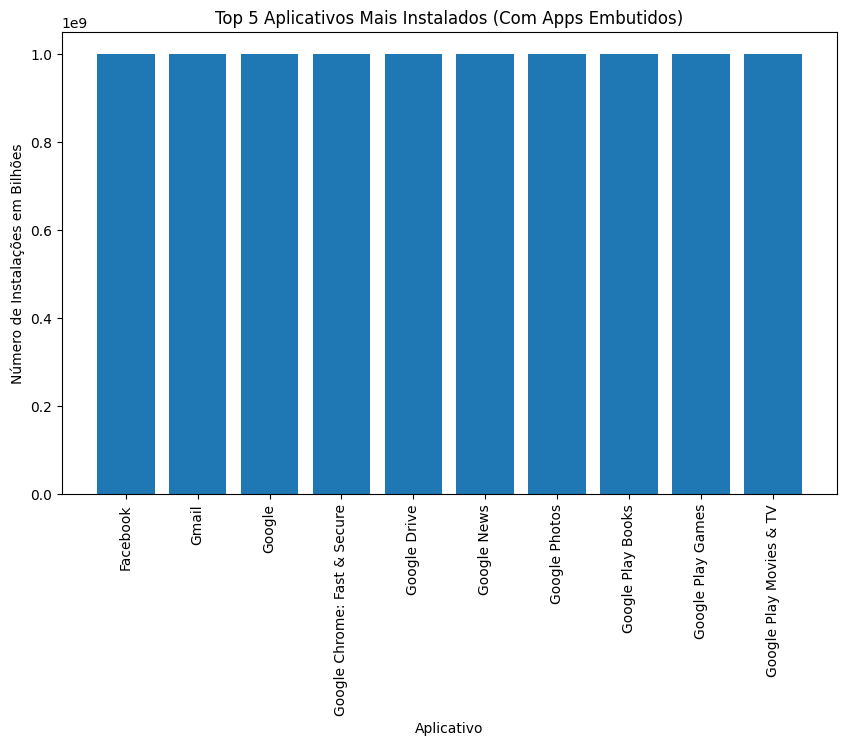

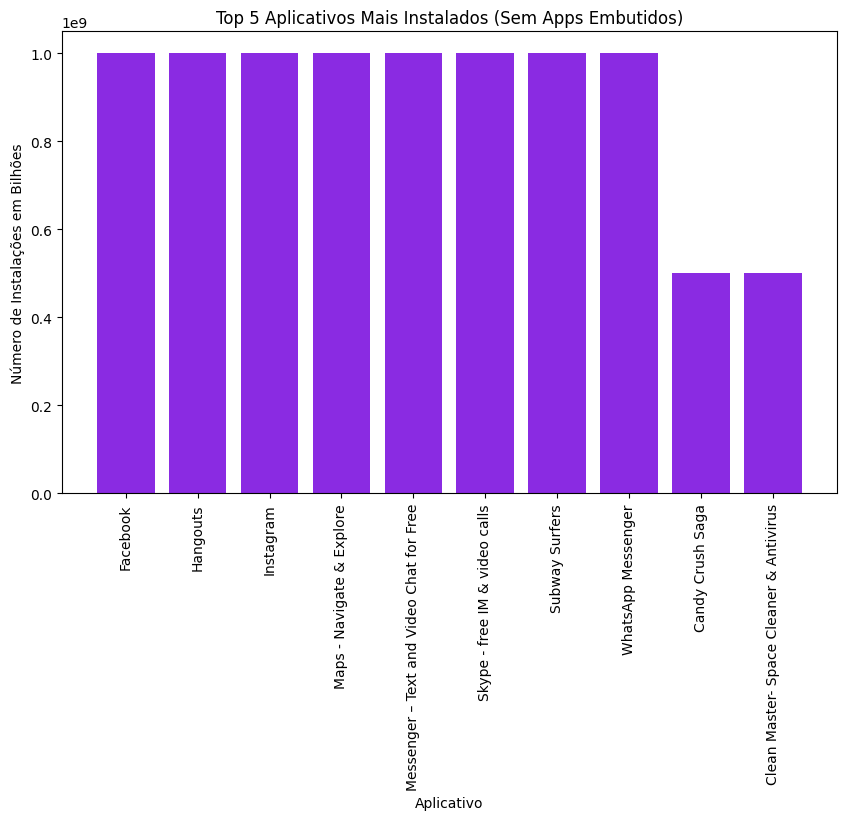

In [22]:
# Grafico de barras contando apps pre instalados_____________________________________
pre_installs_head = installs_dataframe_for_plot.head(10)

# Configurar o tamanho da figura
plt.figure(figsize=(10, 6))

# Criar o gráfico de barras
plt.bar(pre_installs_head[APP], pre_installs_head[INSTALLS])

# Rotacionar os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=90)

# Adicionar título e rótulos dos eixos
plt.title('Top 5 Aplicativos Mais Instalados (Com Apps Embutidos)')
plt.xlabel('Aplicativo')
plt.ylabel('Número de Instalações em Bilhões')

# Exibir o gráfico
plt.show()

# Grafico de barras sem apps pre instalados___________________________________________
not_pre_installs_head = not_pre_installs_dataframe.head(10)

# Configurar o tamanho da figura
plt.figure(figsize=(10, 6))

# Criar o gráfico de barras
plt.bar(not_pre_installs_head[APP], not_pre_installs_head[INSTALLS], color='blueviolet')

# Rotacionar os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=90)

# Adicionar título e rótulos dos eixos
plt.title('Top 5 Aplicativos Mais Instalados (Sem Apps Embutidos)')
plt.xlabel('Aplicativo')
plt.ylabel('Número de Instalações em Bilhões')

# Exibir o gráfico
plt.show()

### 3. Frequências de Categorias

Primeiramente vamos observar os dados da coluna "Category":

In [23]:
# Exibindo 5 registros variados da coluna "Category"
display_df_table(distinct_dataframe[::randint(1700, 2000)][CATEGORY].head())
# Este bloco pode ser executado diversas vezes para ter maior noção dos dados

|      | Category       |
|-----:|:---------------|
|    0 | ART_AND_DESIGN |
| 2102 | FAMILY         |
| 4190 | LIFESTYLE      |
| 6066 | FAMILY         |
| 7947 | BUSINESS       |

Podemos notar que o formato padrão para esta coluna são palavras em letras maíuscula separadas por *underline*.

Vamos filtrar os registros que não seguem esta regra:

In [24]:
# Expressão regular que checa letras maíusculas e underline
category_pattern = r"[A-Z_]"

# Cria um objeto Series com valores True|False que serve como máscara de busca 
category_mask = valid_app_dataframe[CATEGORY].str.match(category_pattern)

# Usa máscara criada para filtrar as linhas com "Category" válidas
valid_category_dataframe = valid_app_dataframe[category_mask]

removed_registers = (len(valid_app_dataframe) - len(valid_category_dataframe))

print(f"Número de Registros Bruto: {len(distinct_dataframe):>14}")
print(f"Número de Registros Válidos: {len(valid_category_dataframe):>12}")
print(f"Número de Registros Removidos: {removed_registers:>10}")

Número de Registros Bruto:          10358
Número de Registros Válidos:        10357
Número de Registros Removidos:          1


Agora podemos criar uma tabela com a frequência das categorias e gerar o gráfico pedido:

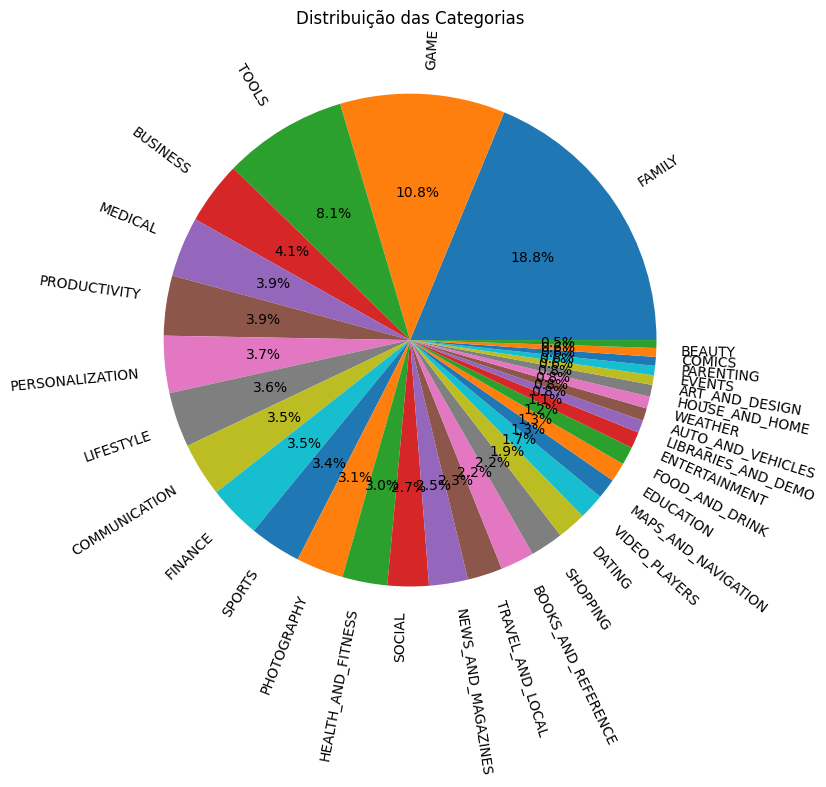

In [50]:
# Cria um novo dataframe com a contagem de registros por categoria
group_by_category_dataframe = valid_category_dataframe.groupby(CATEGORY).size().reset_index(name="Count")

# Ordenando as categorias por quantidade
sorted_group_by_category_dataframe = group_by_category_dataframe.sort_values(by="Count", ascending=False)

# Gerando gráfico com a contagem das categorias_________________________________________

# Extraindo os nomes das categorias e contagens do dataframe
categories = sorted_group_by_category_dataframe[CATEGORY]
counts = sorted_group_by_category_dataframe["Count"]

# Criando o grafico de pizza
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=0, rotatelabels=True)
plt.title("Distribuição das Categorias")

# Apresentando o gráfico
plt.show()

Como podemos notar, a visualição do gráfico é prejudicada pela quantidade execessiva de categorias existente na tabela.

Uma maneira que podemos representar grandes distribuições de frequências é com histogramas:

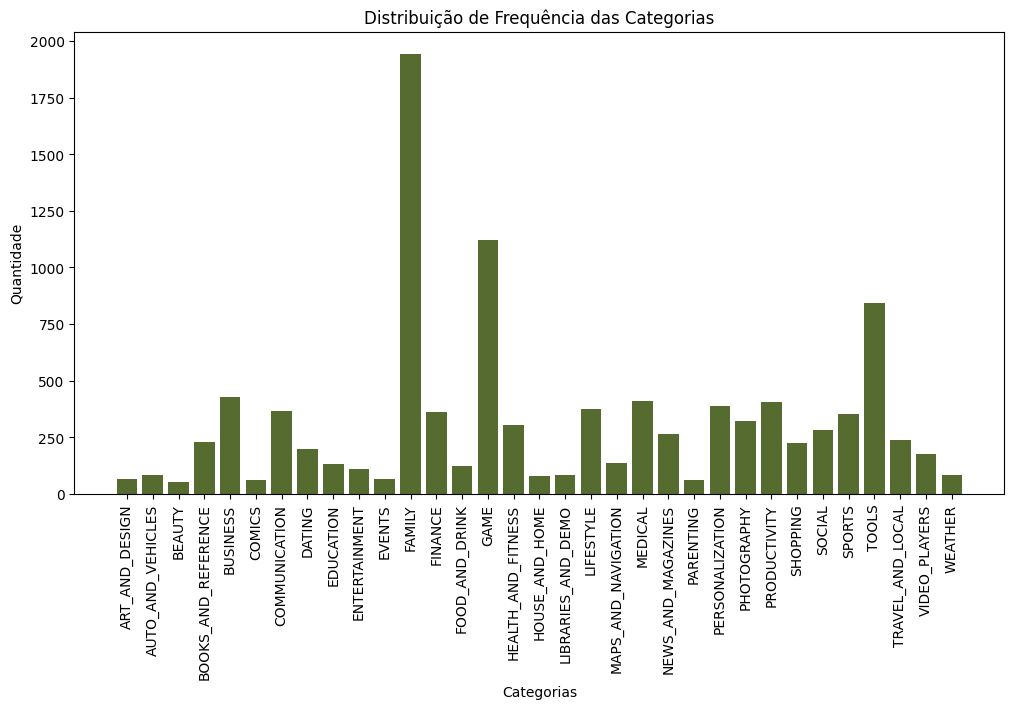

In [52]:
# Gerando histograma com a contagem das categorias_______________________________________
plt.figure(figsize=(12, 6))
plt.bar(group_by_category_dataframe[CATEGORY], group_by_category_dataframe['Count'], color='darkolivegreen')

# Adicionando rótulos e título
plt.xlabel('Categorias')
plt.ylabel('Quantidade')
plt.title('Distribuição de Frequência de Categorias')

# Rotacionando os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=90)

# Apresentando o gráfico
plt.show()